# Generative Model for Wine Tasting Notes

## Overview

Wine tasting notes are often viewed as an invaluable part of the wine purchasing decision. Wine tasting notes by professionals, such as Wine Spectator and Wine Advocate, are often printed and used by commercial retailers as an immutable guide to wines sold.

However, objectivity in these notes can often be difficult due to expression of only 1/3 of nose receptor phenotypes in humans, leading to vast differences in tasting experience. Furthermore, tasting events often contain 100s, or 1000s, or wines, which can cause fatigue in even the most experienced of tasters.

Finally, tasting is often confounded by the lack of a common language, and indeed, a common cultural background against which to compare aromas and smells.

The WSET has produced a <a href='https://www.wsetglobal.com/media/3119/wset_l3_wines_sat_en_jun-2016.pdf'>tasting rubric</a>, in an attempt to create a common wine vocabulary, quantifying not just aroma but body and taste, as well.

In 2002, A.C. Noble created a wine wheel during her time at UC DAVIS. This wine wheel was revolutionary, not because it created a common language, but because it came with instructions to create a reproducible standard for each aromatic note from common supermarket ingredients.

<img src="img/Davis-Wine-Aroma-Wheel1.jpg" alt="wine_wheel" width="300"/>

My project will examine 10,000s of tastings notes created to determine if it is able to create passable wine notes based on an initial seed and whether a deep-learning model can be trained to generate appropriate looking wine-tasting notes.

## Model Considerations

The created model should be able to give a wine note that reads naturally and could conceivably describe a wine. Models will be created and run against an initial seed word and compared against a pre-trained model, DistilGPT2, to compare performance against an existing transformer model.

Human rating of the generated sentences would be the best metric to score the various models, as most scores currently only score based on exact re-creation of the sentence and do not account for variance in the sentences or replacement of words with suitable synonyms.

However, Bleu and Rouge will be used as a generic reporting metric to briefly help in comparison against other models in the field.

Initial Hypothesis

## Import Data

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

pd.set_option('display.max_colwidth', None)
plt.style.use('bmh')
%matplotlib inline  

In [3]:
wine_df = pd.read_csv('wine_df_full.csv').drop(columns = 'Unnamed: 0')

## Functions

In [2]:
def words_of_interest(vec, initial_word_list, suptitle, list_of_titles, fig_size):
    '''function takes an instantiated feature extractor (countvectorizer) and:
    1. creates a dataseries of words 
    2. returns the 25 most common and least common words in the dataseries
    3. plots a bar plot of the 15 most and least commong words'''
    converted_word_list = vec.fit_transform(initial_word_list)                        # Transforms dataseries
    sum_words = converted_word_list.sum(axis=0)                                       # Sum along the column
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] # List of tuples (word, freq)    
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)               # Sorts list in descending order
    word_pd = pd.DataFrame(
        columns = ['word', 'frequency'],
        data = words_freq
    )
    
    fig, axs = plt.subplots(1, 2, figsize = fig_size)
    fig.suptitle(suptitle, fontsize = 18)
    fig.tight_layout(pad = 0, w_pad = 8.0, h_pad = 1.0 , rect = [0, 0, 1, 0.95]) 
    
    axs[0].set_title(list_of_titles[0], fontsize = 12)
    sns.barplot(
        ax = axs[0],
        y = 'word',
        x = 'frequency',
        palette = 'dark:blue',
        data = word_pd.head(15)
    )
    
    axs[1].set_title(list_of_titles[1], fontsize = 12)
    sns.barplot(
        ax = axs[1],
        y = 'word',
        x = 'frequency',
        palette = 'light:blue',
        data = word_pd.tail(15)
    )

## Data Cleaning & Cleaning

In [4]:
wine_df['wine_notes']

0                                                   Maturing well, this round red is a lovely example of the traditional style. Orange peel, dried cherry, forest floor, vanilla and black tea flavors mingle harmoniously over round tannins and citrusy acidity. Generous but gentle, lively, balanced and harmonious. Tempranillo and Mazuelo. Drink now through 2030. 7,500 cases made, 680 cases imported. —TM
1                                                                                                                                                    Powerful and structured, with minerally richness to the fine-edged red fruit and savory spice flavors. The sleek finish offers impressive purity and clarity to the notes of hot stone, flint and underbrush. Best from 2021 through 2026. 993 cases made. —KM
2                                                                                                                       Effusive aromas of black currant, blueberry, violet and iron mark this e

An initial examination shows that some tasting notes have authors notes at the end that will have to be removed.

In [5]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80887 entries, 0 to 80886
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   wine        80887 non-null  object
 1   wine_notes  80715 non-null  object
 2   vintage     79625 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


In [6]:
wine_df.loc[wine_df['wine_notes'].isna(), :]

,wine,wine_notes,vintage
3797,Bastor-Lamontagne,NaN,NaN
3844,Bastor-Lamontagne,NaN,NaN
3921,Bastor-Lamontagne,NaN,90\nRP
4080,Bastor-Lamontagne,NaN,85\nRP
4112,Bastor-Lamontagne,NaN,90\nRP
...,...,...,...
80432,Grands Fers Fleurie,NaN,2009
80434,Chenin Blanc Stellenbosch,NaN,2009
80436,Chardonnay Napa Valley,NaN,2009
80554,Bechtheimer Einzigacker Weisser Burgunder,NaN,2009


In [7]:
wine_df.dropna(inplace = True)

A number of wines were only rated and a tasting note was not written. These were removed frm the dataset.

In [8]:
wine_df.describe()

,wine,wine_notes,vintage
count,79456,79456,79456
unique,34075,61553,223
top,Chateauneuf-du-Pape,Also recommended.,2012
freq,419,638,11733


### Duplicated Rows

In [9]:
wine_df.duplicated().value_counts()

False    62389
True     17067
dtype: int64

#### Tasting notes for the same wine

Tasting notes that had the same wine and vintage were examined to determine if they would be an issue.

In [10]:
wine_df[wine_df.duplicated(subset = ['wine', 'vintage']) == True]

,wine,wine_notes,vintage
100,Bodegas Marqués de Murrieta Rioja Castillo Ygay Gran Reserva Especial\n-,"Maturing well, this round red is a lovely example of the traditional style. Orange peel, dried cherry, forest floor, vanilla and black tea flavors mingle harmoniously over round tannins and citrusy acidity. Generous but gentle, lively, balanced and harmonious. Tempranillo and Mazuelo. Drink now through 2030. 7,500 cases made, 680 cases imported. —TM",2010
101,Aubert Pinot Noir Sonoma Coast UV Vineyard\n-,"Powerful and structured, with minerally richness to the fine-edged red fruit and savory spice flavors. The sleek finish offers impressive purity and clarity to the notes of hot stone, flint and underbrush. Best from 2021 through 2026. 993 cases made. —KM",2018
102,San Filippo Brunello di Montalcino Le Lucére\n-,"Effusive aromas of black currant, blueberry, violet and iron mark this expressive red. Supple and harmonious, with a firm backbone of tannins that are refined and integrated. Shows terrific length and complexity. Best from 2023 through 2043. 1,300 cases made, 650 cases imported. —BS",2015
103,Mayacamas Cabernet Sauvignon Mount Veeder\n-,"This distinctive red throws a lot of wild sage, herb and sassafras notes out first, while the core of intense red currant, damson plum and bitter cherry fruit waits its turn. The vibrant structure is built on acidity, pulling everything together through the iron-streaked finish. Should age wonderfully. Best from 2022 through 2040. 1,600 cases made. —JM",2016
104,Domaine de la Vieille Julienne Châteauneuf-du-Pape Les Trois Sources\n-,"A lush, ripe style, with açaí berry, blueberry and plum reduction notes giving this a slightly exotic bent, while singed bay leaf, worn leather and warm tar accents keep this grounded in a slightly old-school way. Displays ample heft, yet energy ripples through the finish, accompanied by lingering garrigue and tobacco echoes. Best from 2022 through 2040. 2,000 cases made, 500 cases imported. —JM",2016
...,...,...,...
80875,Val de Sil Valdeorras,"(100% godello) Light, bright gold. Expressive aromas of soft citrus fruits, white peach and dried flowers, complemented by a suggestion of smoky lees. Creamy in texture and quite dry, with a tactile quality to the gently smoky orchard and pit fruit flavors. Finishes on a firm mineral note with admirable precision. I like this wine's mix of richness and vivacity.",2009
80876,Mencia Avante Vino de la Tierra de Castilla Y Leon,"(100% mencia, 70% barrel-aged and the rest done in stainless steel) Vivid ruby. Highly fragrant aromas of red and dark berries, cola, smoky herbs and minerals. Juicy and precise, offering tangy black raspberry and bitter cherry flavors, with a strong mineral overtone. The mineral note carries through a long, sappy and refreshingly bright finish, which features a hint of spicy oak. This wine's energy makes it drink well now, but it's balanced to age for at least a few more years.",2009
80877,Naia Verdejo Rueda,"Vivid gold. Pear, quince and tangerine on the nose, with notes of green almond and honey adding complexity. Smooth in texture and rather rich for the category, offering deep orchard fruit flavors and a hint of smokiness, likely from the partial barrel-fermentation. Becomes spicier with air and finishes with very good punch and an echo of pear. Not a classic verdejo, but a delicious white wine.",2009
80880,Rioja,"(100% tempranillo raised completely in stainless steel) Vivid red. Lively aromas of redcurrant and wild strawberry, with subtle floral and spice notes adding complexity. Pure and precise, offering finely etched red fruit and floral flavors and a seamless texture. Fine-grained tannins add shape to the tangy, very persistent finish. This is a superb value.",2009


In [11]:
wine_df.loc[(wine_df['wine'] == 'Val de Sil Valdeorras') &
            (wine_df['vintage'] == '2009'), 
            :]

,wine,wine_notes,vintage
78009,Val de Sil Valdeorras,"(100% godello) Light, bright gold. Expressive aromas of soft citrus fruits, white peach and dried flowers, complemented by a suggestion of smoky lees. Creamy in texture and quite dry, with a tactile quality to the gently smoky orchard and pit fruit flavors. Finishes on a firm mineral note with admirable precision. I like this wine's mix of richness and vivacity.",2009
79684,Val de Sil Valdeorras,"(100% godello) Light, bright gold. Expressive aromas of soft citrus fruits, white peach and dried flowers, complemented by a suggestion of smoky lees. Creamy in texture and quite dry, with a tactile quality to the gently smoky orchard and pit fruit flavors. Finishes on a firm mineral note with admirable precision. I like this wine's mix of richness and vivacity.",2009
80875,Val de Sil Valdeorras,"(100% godello) Light, bright gold. Expressive aromas of soft citrus fruits, white peach and dried flowers, complemented by a suggestion of smoky lees. Creamy in texture and quite dry, with a tactile quality to the gently smoky orchard and pit fruit flavors. Finishes on a firm mineral note with admirable precision. I like this wine's mix of richness and vivacity.",2009


In [12]:
wine_df.loc[(wine_df['wine'] == 'Rioja') &
            (wine_df['vintage'] == '2009'), 
            :]

,wine,wine_notes,vintage
73284,Rioja,"Opaque ruby. A heady, complex bouquet evokes dark berry preserves, cherry-cola, candied licorice, vanilla and incense, with a zesty mineral note adding vibrancy. Broad, sappy and precise, offering sweet blackberry and violet pastille flavors along with hints of mocha and spicecake. Rich and ample in the style of the vintage, but shows superb energy as well. Finishes sweet, velvety and extremely long, with lingering smokiness and supple, fully integrated tannins. This new project is a partnership between Vega Sicilia and Benjamin de Rothschild, whose branch of that family owns numerous non-Pauillac Bordeaux properties.",2009
76524,Rioja,"Dark ruby. Ripe cherry, blackberry and woodsmoke on the fragrant nose. Plush, open-knit dark fruit flavors show very good depth and are lifted by slow-building minerality. Tangy and bright on the finish, which features notes of bittter cherry and black pepper.",2009
79344,Rioja,"(100% tempranillo) Inky ruby. Bright red fruit and floral aromas are complemented by notes of white pepper and baking spices. Fresh, mineral-driven raspberry and cherry flavors are well-focused and pure, gaining depth with air. Juicy, energetic and persistent on the finish, which repeats the spicy note.",2009
80880,Rioja,"(100% tempranillo raised completely in stainless steel) Vivid red. Lively aromas of redcurrant and wild strawberry, with subtle floral and spice notes adding complexity. Pure and precise, offering finely etched red fruit and floral flavors and a seamless texture. Fine-grained tannins add shape to the tangy, very persistent finish. This is a superb value.",2009


In general, tasting notes that were of duplicate wines and vintages were typically in the following categories:
 1. The same wine but with an appellation or style as their name, meaning that the specific wine name may not have been kept
 2. Wines that were the same but written by different authors who had rated or tasted the same wine
 3. Multiple duplicated entries that had the same tasting note, likely because they were accidentally entered multiple times.
 
In the case of 1 & 2, the notes were kept as they were different tasting notes. In the case of 3, they were removed in the next step.

#### Duplicate tasting notes

In [13]:
wine_df.loc[wine_df['wine_notes'] == 'Also recommended.', :]

,wine,wine_notes,vintage
11503,Carignan BTT Gran Reserva,Also recommended.,2019
15816,Rosé Cabernet Franc Estate Vineyards,Also recommended.,2019
15817,Rosé Pinot Noir Becklin Vineyards Georgia,Also recommended.,2019
15818,White Wine Blend Mith,Also recommended.,2019
15819,Sauvignon Blanc Canoe Ridge Vineyard The Expedition,Also recommended.,2019
...,...,...,...
63766,Sangiovese Helix Stillwater Creek Vineyard,Also recommended.,2010
63767,Red Wine Into the Void,Also recommended.,2010
75133,Red Wine Justice,Also recommended.,2009
75149,Lauro,Also recommended.,2009


In [14]:
wine_df.duplicated(subset = 'wine_notes').sum()

17903

In [15]:
wine_df['wine_notes'][wine_df.duplicated(subset = 'wine_notes')].value_counts()

Also recommended.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       637
Also recommended                                                            

In [16]:
wine_df.drop_duplicates(subset = 'wine_notes', inplace = True)

In [17]:
wine_df.reset_index(drop = True, inplace = True)

A number of duplicate tasting notes were found, either with a short description by writers who likely did not have the time or inclination to write a full note, as well as previously indicated, duplicate entries.

These were removed to prevent duplicate entries.

#### Wine Note Length

In [18]:
wine_df.shape

(61553, 3)

In [21]:
wine_df['note_length'] = wine_df['wine_notes'].map(lambda x: len(x.split(' ')))
wine_df['note_length'].describe()

count    61553.000000
mean        62.722467
std         28.690289
min          1.000000
25%         48.000000
50%         58.000000
75%         70.000000
max        856.000000
Name: note_length, dtype: float64

In [22]:
wine_df.loc[wine_df['note_length'] > 200, 'wine_notes']

113                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               The 2020 Reserva Branco Porta da Ravessa is a blend of 40% Verdelho, 30% Arinto and 30% Antão Vaz, unoaked but for the Verdelho, which spent three months in used French oak. It comes in very dry and at 12.2% alcohol. The wood obvi

Wine notes greater than 200 words were examined to determine why it was so long. Tasting notes pertinent to commercial implementation (in supermarkets, or on brochures) would have to be short and convey all the pertinent information quickly.

In general, the longer tasting notes began to contain a lot personal detail from the writer, including personal anecdotes or contextual information about the winery and more. With a goal in mind of creating a short snippet for the purpose of the general public that conveys the most pertinent information on flavours and aromas of the wine, these will be removed as they will take away from the central ideas of conveying just the taste of the wine.

Along with this, we do see notes that end with phone numbers, importers, and websites. All of these will also be removed.

In [23]:
wine_df.loc[wine_df['note_length'] < 25, 'wine_notes']

235      A sweet, berry-fruited blend, the 2016 Cabernet Sauvignon is a polished, uncomplicated and commercial offering from 14 Hands Winery that's made for near-term consumption.
529                                                                                                        Red values under $25. Recommended and tasted, but no tasting note given.
578                                                                                                                                           Tel. (503) 662-4509; www.adeawine.com
610                                                                                                                                        Also recommended, no tasting note given.
615                                                                                                                                                      No tasting note was given.
                                                                                            ...     

Wine notes below the word length of 25 show a number of notes that did not contain an actual tasting note, as well as a mix of pertinent tasting notes.

However, as we intend to later use a seed of 15 words to generate finished tasting notes to judge model performance, we will drop anything below 25 words to allow the models enough of a word length to generate a tasting note worth examining.

In [ ]:
# Removing author initials
for row in wine_df.index:
    wine_df['wine_notes'][row] = re.sub('\—[a-zA-Z]+', '', wine_df['wine_notes'][row])
    wine_df['wine_notes'][row] = re.sub(r'(importer: )[\s\S]+', "", wine_df['wine_notes'][row])
    wine_df['wine_notes'][row] = re.sub(r'(tel. )(\(\d+\))\s\d+\-\d+[,;]?', "", wine_df['wine_notes'][row])
    wine_df['wine_notes'][row] = re.sub(r'(www.)\w+.\w+', "", wine_df['wine_notes'][row])

In [24]:
wine_df_clean = wine_df.loc[wine_df['note_length'] < 75, :]

In [25]:
wine_df_clean = wine_df_clean.loc[wine_df['note_length'] > 25, :]

In [26]:
wine_df_clean.shape

(48898, 4)

#### Saving Cleaned Data

In [19]:
wine_df.to_csv('wine_df_full_clean.csv')

## Data EDA

### Distribution of word counts

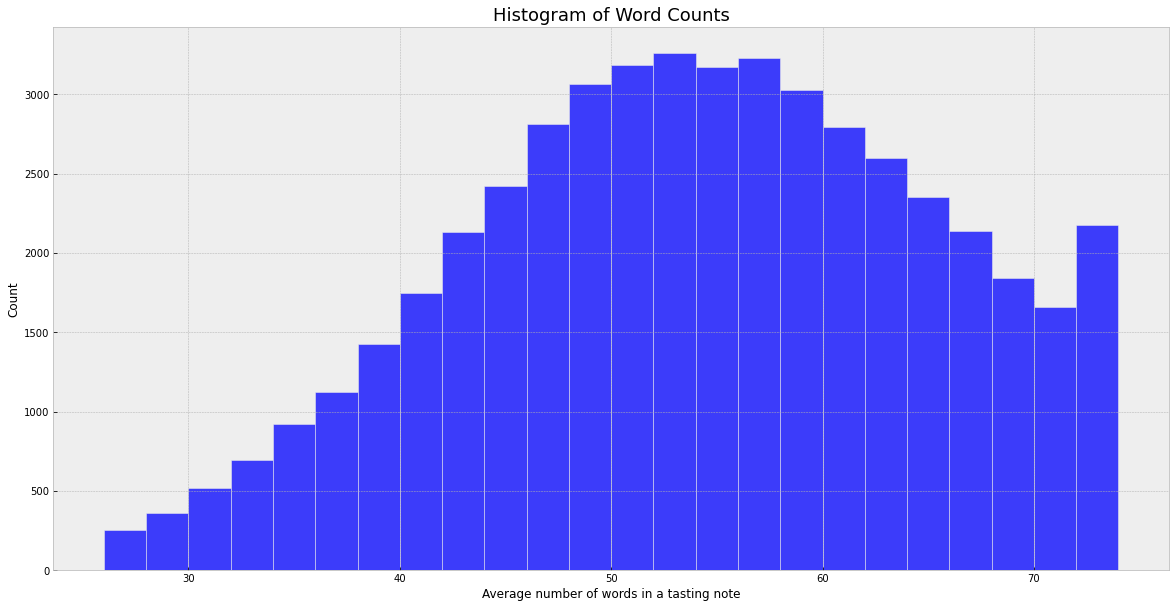

In [27]:
plt.figure(figsize = (20,10))
plt.title('Histogram of Word Counts', fontsize = 18)
plt.xlabel('Average number of words in a tasting note')
sns.histplot(
    x = 'note_length',
    data = wine_df_clean,
    bins = 24,
    );

We see a distribution of the word counts that somewhat resembles a normal distrubtion, when examining only tasting notes between 25 and 75 words, with a slight left skew and a peak for the most common words between 50-60 words.

We also see a slight jump in the notes at 75 words.

### Most Common and Least Common Words

In [28]:
wine_notes = [x.lower() for x in wine_df_clean['wine_notes']]

In [29]:
tokenizer = Tokenizer()
corpus = wine_notes
tokenizer.fit_on_texts(corpus)

In [30]:
word_count = tokenizer.word_counts

In [31]:
sorted_count = sorted(word_count.items(), key=lambda x: x[1], reverse = True)

In [32]:
word_count_df = pd.DataFrame(
    columns = ['Word', 'Count'],
    data = sorted_count)

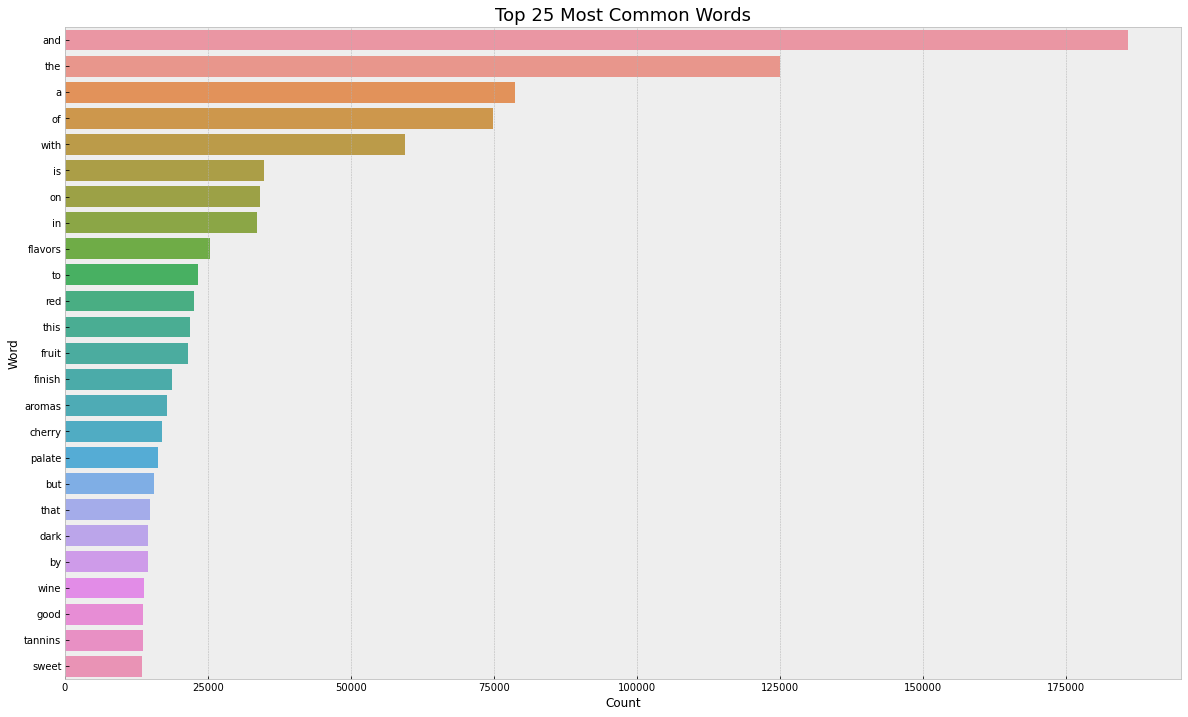

In [33]:
plt.figure(figsize = (20,12))
plt.title('Top 25 Most Common Words', fontsize = 18)
plt.xlabel('Frequency of Word Occurrence')
sns.barplot(
    data = word_count_df[0:25],
    x = 'Count',
    y = 'Word',
    orient = 'h'
);

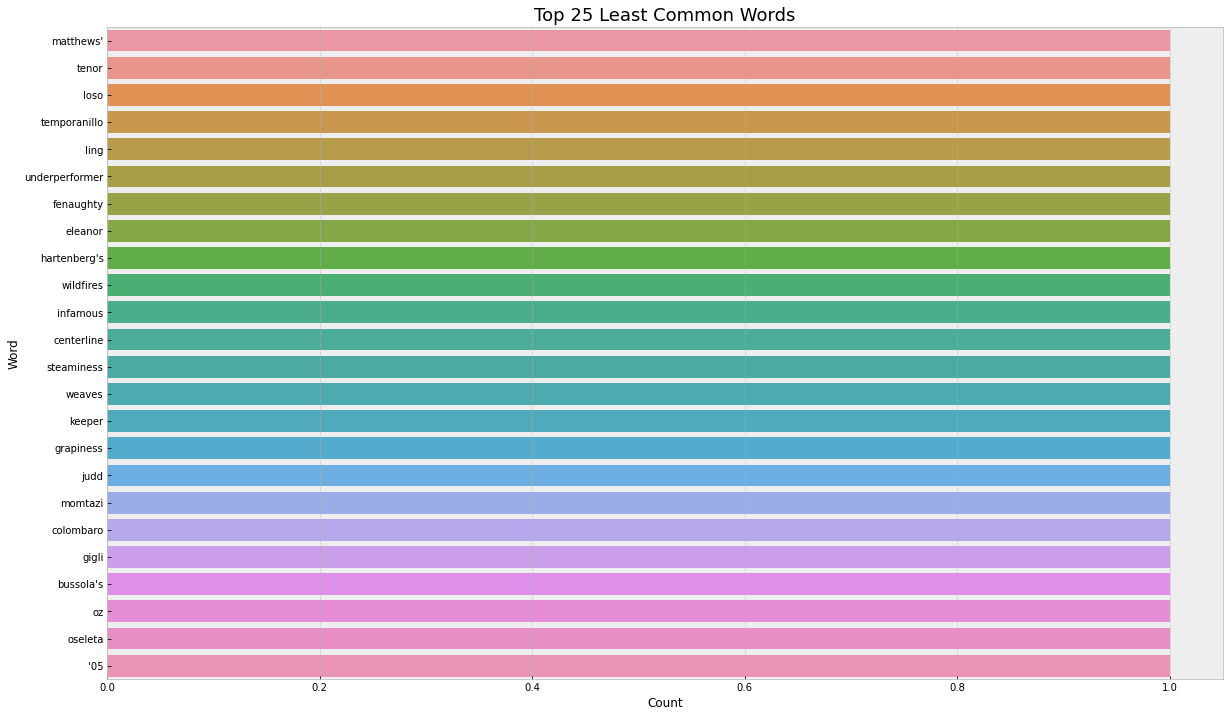

In [34]:
plt.figure(figsize = (20,12))
plt.title('Top 25 Least Common Words', fontsize = 18)
plt.xlabel('Frequency of Word Occurrence')
sns.barplot(
    data = word_count_df[:-25:-1],
    x = 'Count',
    y = 'Word',
    orient = 'h'
);

When examining the most and least words present in the tasting notes, the most common show many common English stop words, along with some wine specific terms, such as flavours, fruit, aromas, and finish, which are all terms we are looking to target.

In the least common words, all of which only occurred once, we do see a lot of proper nouns that are likely names, as well as some uncommon events that make influence wine armoas, such as wildfires.

#### Most common n_gram words

In the next graphs, we removed the common English Stop words, as well as limiting the max number of features to 2500, to exmine "more common" least occurring words.

We then examined common n_grams (1, 2, 3) to determine if there are common n_grams in the words.

The top 25 most common terms are: 
[('flavors', 30055), ('fruit', 28308), ('red', 27787), ('wine', 25254), ('finish', 24645), ('palate', 21583), ('aromas', 21557), ('cherry', 19636), ('dark', 17825), ('sweet', 17101), ('tannins', 17046), ('nose', 16684), ('bright', 16291), ('good', 15901), ('floral', 13949), ('notes', 13396), ('ruby', 12359), ('finishes', 12337), ('black', 12062), ('long', 11275), ('juicy', 11048), ('offering', 10716), ('ripe', 10604), ('oak', 10546), ('acidity', 10499)] 
---------------

 The top 25 least common terms are: 
[('urgency', 80), ('tapering', 80), ('unfurl', 80), ('caraway', 80), ('denser', 80), ('central', 80), ('blocked', 80), ('sublime', 80), ('34', 80), ('smudged', 80), ('michael', 80), ('available', 80), ('hudson', 80), ('begin', 80), ('tend', 80), ('elegantly', 80), ('pulling', 80), ('cannubi', 81), ('emphatic', 81), ('underpinnings', 81), ('valmur', 81), ('sauternes', 81), ('castelli', 81), ('sits', 81)] 
---------------



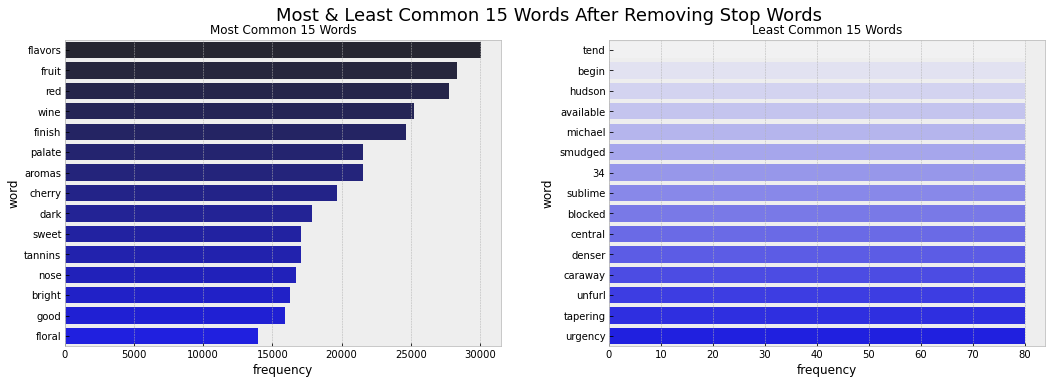

In [35]:
cvec_stop_words = CountVectorizer(
    max_features = 2500,
    stop_words = ENGLISH_STOP_WORDS
)

titles =['Most Common 15 Words', 'Least Common 15 Words']

words_of_interest(
    cvec_stop_words, 
    wine_df['wine_notes'],
    'Most & Least Common 15 Words After Removing Stop Words', 
    titles, 
    (14,5)
);

Similar to the most common words, we see a more interesting trend of what the most common words and aromas are. While many of these are non-descriptors, we do see the words "cherry", "sweet" and "floral" coming up fairly often.

Another interesting thing to note is that while some of the other words that come up may be descriptors, they can also be used to describe colour, such as "bright" and "dark", which may lead to an over representation of them.

The top 25 most common terms are: 
[('fruit flavors', 4723), ('dark berry', 4687), ('cabernet sauvignon', 4317), ('palate offering', 3714), ('red fruit', 3699), ('bitter cherry', 3436), ('ruby red', 3244), ('red berry', 3163), ('medium bodied', 3101), ('black raspberry', 2910), ('white pepper', 2884), ('dark fruit', 2494), ('dark berries', 2448), ('red cherry', 2407), ('red berries', 2329), ('bright ruby', 2324), ('cherry flavors', 2320), ('palate medium', 2285), ('pinot noir', 2282), ('french oak', 2279), ('fine grained', 2272), ('dark red', 2199), ('white flowers', 2117), ('black cherry', 1915), ('new oak', 1894)] 
---------------

 The top 25 least common terms are: 
[('cherries tobacco', 96), ('lifted zesty', 96), ('bright long', 96), ('lusciously lingering', 96), ('nose melds', 96), ('fruit picked', 96), ('graphite smoke', 96), ('firmed dusty', 96), ('complexity juicy', 96), ('herbs flowers', 96), ('finishes impressive', 96), ('strong impression', 96), ('offering nervy', 96), ('he

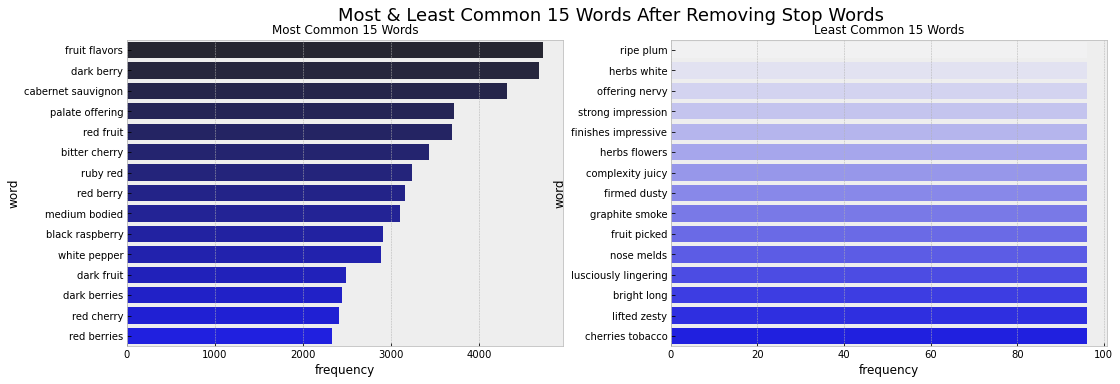

In [36]:
cvec_2_stop_words = CountVectorizer(
    max_features = 2500,
    stop_words = ENGLISH_STOP_WORDS,
    ngram_range = (2,2)
)

titles =['Most Common 15 Words', 'Least Common 15 Words']

words_of_interest(
    cvec_2_stop_words, 
    wine_df['wine_notes'],
    'Most & Least Common 15 Words After Removing Stop Words', 
    titles, 
    (14,5)
);

Specific bigrams do show up often in the tasting notes and here we can see how specific words get over represented, like "dark" and "red".

We also do see the most common wine type being Cabernet Sauvignon and appearing the most. Between this and the fruit representation, it is interesting to note a much stronger skew towards red wine descriptors appearing in the dataset.

This reinforces a long-standing global trend we see towards red wines being seen as "more serious" and being judged more often and often better than white wines.

The top 25 most common terms are: 
[('palate medium bodied', 2277), ('bitter cherry flavors', 1465), ('fine grained tannins', 1215), ('bright ruby red', 1214), ('dark berry flavors', 1199), ('red dark berry', 1117), ('black blue fruit', 1048), ('floral pastille flavors', 881), ('orchard fruit flavors', 841), ('new french oak', 816), ('red fruit flavors', 809), ('black raspberry cherry', 795), ('raspberry bitter cherry', 720), ('focused palate offering', 698), ('dark fruit flavors', 691), ('red berry fruit', 637), ('offering bitter cherry', 623), ('citrus orchard fruit', 619), ('high pitched aromas', 569), ('black blue fruits', 567), ('year old vines', 562), ('fine bead acidity', 541), ('blue fruit flavors', 527), ('cherry dark berry', 507), ('pale bright yellow', 504)] 
---------------

 The top 25 least common terms are: 
[('smoky dark berry', 39), ('golden yellow rich', 39), ('floral quality comes', 39), ('aromas yellow apple', 39), ('red musky red', 39), ('saturated ruby ripe', 39),

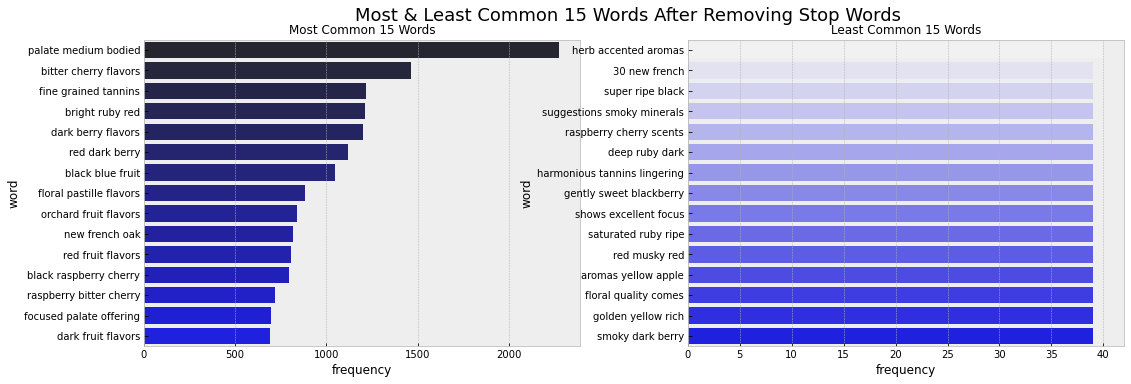

In [37]:
cvec_3_stop_words = CountVectorizer(
    max_features = 2500,
    stop_words = ENGLISH_STOP_WORDS,
    ngram_range = (3,3)
)

titles =['Most Common 15 Words', 'Least Common 15 Words']

words_of_interest(
    cvec_3_stop_words, 
    wine_df['wine_notes'],
    'Most & Least Common 15 Words After Removing Stop Words', 
    titles, 
    (14,5)
);

Trigrams that are common are mostly an expansion of the bigrams, although we do see some new flavours, such as "new french oak", that wasn't captured in the unigrams and bigrams, but also indicates a skew towards bigger, bolder flavours.

Again, we do see a strong skew towards red wine descriptors.

One good thing to note is that the unigrams, bigrams, and trigrams do echo the general taste trends of the average consumer, skewing towards both red wines, and younger wines, which will create a model that is more applicable to the wines that are likely to be sold more commercially.

## Test Dataset

Unlike many supervised models, where the data set can split into a training and test set to determine model accuracy and performance, a language model should be fed as much data as possible.

Instead, to test the model, BLEU and ROUGE will be used to compare the generated text against a 'ground truth'. In order to do this, we created a new test set that splits tasting notes into the:
- 1st 15 words 
- The remainder of the tasting note

This will allow us to generate the remainder of the note based on the initial seed and compare it to the 'ground truth'.

In [39]:
' '.join(wine_df_clean['wine_notes'][0].split()[0:15])

'Maturing well, this round red is a lovely example of the traditional style. Orange peel,'

In [40]:
start_sequences = [' '.join(x.split()[:15]) for x in wine_df_clean['wine_notes']]
end_sequences = [' '.join(x.split()[15:]) for x in wine_df_clean['wine_notes']]

In [41]:
test_table = pd.DataFrame(
    data = [start_sequences, end_sequences]
).T

In [42]:
test_table.columns = ['start_seq', 'end_seq']

In [43]:
# testing a random selection of the start_seq
random_pick = np.random.randint(49064)
print(test_table.iloc[random_pick,0])

(14.5% alcohol): Pale yellow. Very subtle but rather wild aromas of peach skin, lemon peel


In [82]:
repeat_seq = pd.DataFrame(test_table['start_seq'].value_counts())
repeat_seq = repeat_seq[repeat_seq['start_seq'] > 1].reset_index().drop(columns = ['start_seq'])
repeat_seq

,index
0,"This house tends to produce quite full-bodied, rich, alcoholic, spirited vintage ports that never have"
1,"Subtle bouquet of gooseberry and nut oil, with a trace of something floral. On the"
2,"In April 1991, I had the opportunity to taste (from a friend's cellar in Bordeaux)"
3,(made from vines that are reportedly over 80 years old and aged in new French
4,"Croft never seems to get much publicity since the wines, while always very good, sometimes"
...,...
60,"Peach pit, nut oil and persimmon on the nose. Sweet apricot fruit, toasted pine nuts"
61,"The Pinot Noirs are straightforward, red fruit-driven wines with medium body, tart acidity, and subtle"
62,"Waxy aromas of peach, acacia blossom, smoked meat and toasted oak. Full-bodied, rich and spicy,"
63,"Pink grapefruit, passion fruit and lime zest on the appealing nose. Juicy white peach and"


### Identical Start Sequences

In [49]:
test_table[test_table['start_seq'] == 'This house tends to produce quite full-bodied, rich, alcoholic, spirited vintage ports that never have']

,start_seq,end_seq
808,"This house tends to produce quite full-bodied, rich, alcoholic, spirited vintage ports that never have","a great deal of complexity or finesse but offer meaty, chocolaty, spicy, full-bodied, alcoholic flavors at the expense of elegance. The 1975 is light, a little alcoholic, and not terribly distinguished."
880,"This house tends to produce quite full-bodied, rich, alcoholic, spirited vintage ports that never have","a great deal of complexity or finesse but offer meaty, chocolaty, spicy, full-bodied, alcoholic flavors at the expense of elegance. The 1970 is big and powerful and just now reaching maturity."
948,"This house tends to produce quite full-bodied, rich, alcoholic, spirited vintage ports that never have","a great deal of complexity or finesse but offer meaty, chocolaty, spicy, full-bodied, alcoholic flavors at the expense of elegance.The 1963 is fully mature, spicy, with a chocolaty, meaty texture and somewhat hot, short finish."


In [60]:
test_table[test_table['start_seq'] == 'Lively bouquet of white peach, apple blossom and mint. Soft and gentle, with sweet apricot']

,start_seq,end_seq
23310,"Lively bouquet of white peach, apple blossom and mint. Soft and gentle, with sweet apricot","fruit nicely balanced by ripe but understated acidity. Elegant and persistent, this Spätlese remains light and refreshing."
30815,"Lively bouquet of white peach, apple blossom and mint. Soft and gentle, with sweet apricot","fruit nicely balanced by ripe but understated acidity. A well-balanced wine with appealing length, this spÃ¤tlese remains light and elegant."


Upon splitting, we do see a number of of tasting notes with very similar starting sequences. However, a number of these apply to wines at the same house from different vintages, or the ending sequence does display some variation.

As they are not indicative of the same wine and the tasting notes are not completely identical, we will keep the tasting notes. This will help us generate more variation in the tasting notes, which is more important, than generating exactly what our ground truth will be.

### Saving the Test Dataset

In [83]:
test_table.to_csv('test_table.csv')